# Quantum Variational Rewinding for Time Series Anomaly Detection

In this notebook, we show step-by-step the components of the Quantum Variational Rewinding (QVR) algorithm with explicit code. Then, using the open-source heterogenous workflow \boldsymbolanagement tool - `Covalent` - we stitch together these components to create a workflow. Full documentation for `Covalent` can be found on the RTD page (<https://covalent.readthedocs.io/en/stable/>)

Using this workflow, we employ QVR to train and classify bivariate crpytocurrency time-series which were presented and expained in the main article (which can be found on arXiv). If you have followed the install instructions in `README.md`, you should be able to run the below on your local machine. This has been tested on an 2021 mac m1.

If you are planning on running the code in this notebook, if you haven't already, issue

`> covalent start` 

in a terminal window. If prompted, migrate the databases (this will not happen if this is the first time you launched `Covalent`)

`> covalent db migrate`

To begin, let's do all fo the neccessary imports:

In [1]:
import covalent as ct
import pickle
import os
import pennylane.numpy as np
import numpy as np_norm
import torch
from itertools import cycle
import matplotlib.pyplot as plt
import pennylane as qml
from itertools import combinations
from sklearn.metrics import balanced_accuracy_score, f1_score
# from utils import Optimizer
from pytorch_minimize.optim import MinimizeWrapper

# Need this to resolve paths pater
base_path = os.getcwd()

## Datasets

All of the relevant data is in the `./data/` directory in this repository. We will create a `@ct.electron` to load it.

In Covalent, a `@ct.electron` is analgous to task and can be considered one of the building blocks of a workflow (a `@ct.lattice`). Indeed, in this notebook we create a series of electrons then dispatch them to the local `Covalent` server within a `@ct.lattice`. The benefits of this are (1) you can view the workflow `Covalent` GUI to understand bettter how different parts of the code interact and (2) parts of the workflow are automatically parallelized using `Dask`.

In [2]:
@ct.electron
def load_data_from_pickle(path):
    data = pickle.load(open(path, 'rb'))
    return data

and for good \boldsymboleasure (in case you wish to experiment with code), a sanity check on the format of the training data we are using. We require 3D arrays with dimensions $(m, d, p)$, where (consistent with the article) are:

$m$: The total number of time series in the training dataset $X$

$d$: The dimension of the time series

$p$: The number of discrete time points in the time series

In [3]:
@ct.electron
def data_santity_check(data):
    X = np.asarray(data)
    # Only accept 3d data. (\boldsymbol, d, p)
    if len(X.shape) != 3:
        raise TypeError("Dimensions of X \boldsymbolust be 3 dimensional: (num_series, num_features, num_time_points)")

For training with mini-batches, the data set is processed with a `torch` `Dataloader` object. We will use a helper class and and two `@ct.electron`s to do this (two because we have a batch approximation on the number of time points and on the number of time series).

In [4]:
class DataGetter:
    def __init__(self, X, batch_size):
        self.batch_size = batch_size
        self.data = []
        self.X = X
        self._init_data(
            iter(
                torch.utils.data.DataLoader(
                    self.X, batch_size=self.batch_size, shuffle=True)))

    def _init_data(self, iterator):
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self):
        try:
            return self.data.pop()
        except(IndexError):
            self._init_data(
                iter(
                    torch.utils.data.DataLoader(
                        self.X, batch_size=self.batch_size, shuffle=True)))
            return self.data.pop()

@ct.electron
def get_series_training_cycler(Xtr, n_series_batch):
    x_cycler = DataGetter(Xtr, n_series_batch)
    return x_cycler

@ct.electron
def get_timepoint_training_cycler(Xtr, n_t_batch):
    n_time_points = Xtr.shape[2]
    T  = torch.tensor(np.arange(n_time_points))
    t_cycler = DataGetter(T, n_t_batch)
    return t_cycler

## Building the cost function

Now we need `@ct.electron`'s to define the quantum circuits prepare the $n$-qubit state

$$
|\boldsymbol{x}_i(t_j), \boldsymbol{\alpha}, \boldsymbol{\epsilon} \rangle = W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\epsilon}, t_j)W(\boldsymbol{\alpha})U[\boldsymbol{x}_i(t_j)]|0 \rangle ^{\otimes n}
$$

and estimate the expecation value

$$
\Omega \left(\boldsymbol{x}_i(t_j), \boldsymbol{\alpha}, \boldsymbol{\epsilon}, \boldsymbol{\eta} \right) :=  \langle \boldsymbol{x}_i(t_j), \boldsymbol{\alpha}, \boldsymbol{\epsilon}|\hat{O}_{\boldsymbol{\eta}}|\boldsymbol{x}_i(t_j), \boldsymbol{\alpha}, \boldsymbol{\epsilon} \rangle
$$

Where we chose in the article that 

$$
\hat{O}_{\boldsymbol{\eta}} = \eta_0 I - \frac 1n \sum_{i=1}^{n} \eta_i \hat{\sigma}_z^i
$$

where $\eta_i = 1$ when $i > 0$

The template for the above is the below `@ct.electron`, which leverages `Pennylane` and its interface with `Pytorch`

In [5]:
# Work explicitly with 2 qubits. This corresponds to the 'bivariate model' in the article
n_qubits = 2

@ct.electron
@qml.qnode(qml.device('lightning.qubit', wires=n_qubits, shots=None), interface='torch')
def get_anomaly_expec(x, t, D, alpha, wires, k, embed_func, transform_func, diag_func, observable,
                      embed_func_params={}, transform_func_params={}):

    embed_func(x, wires=wires, **embed_func_params) # U[x_i(t_j)]
    transform_func(alpha, wires, **transform_func_params) # W(\alpha)
    diag_func(D * t, n_qubits, k=k) # D(\epsilon, t_j)
    qml.adjoint(transform_func)(alpha, wires=range(n_qubits), **transform_func_params
        ) # W^{\dagger}(\alpha)
    
    # plug in \hat{O}_{\eta}
    coeffs = np.ones(len(wires))/len(wires) # scale by 1/n
    H = qml.Hamiltonian(coeffs, observable)
     # calculate expecation
    return qml.expval(H)

While $W(\boldsymbol{\alpha})$ and $U[\boldsymbol{x}_i(t_j)]$ can be implemented with quantum circuits in the `Pennylane` templates library, we implement our own code for $D(\boldsymbol{\epsilon}, t_j)$ via a $k$-local approximation of 
$e^{-iM(\epsilon)}$ (see https://dx.doi.org/10.1088/1367-2630/16/3/033040 for explanation)

In [6]:
@ct.electron
def create_diagonal_circuit(D, n, k=None):
    # D is a sub-set of the exponential number of eigenvalues.
    if k is None:
        k = n
    cnt = 0
    # Note there NO explicit loop over all 2^n eigenvalues
    for i in range(1, k + 1):
        for comb in combinations(range(n), i):
            if len(comb) == 1:
                qml.RZ(D[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(D[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)

We can now use `get_anomaly_expec` to build $C_1(\boldsymbol{x}_i(t_j), \boldsymbol{\theta})$, where $\boldsymbol{\theta} = [\boldsymbol{\alpha}, \boldsymbol{\mu}, \boldsymbol{\sigma}, \boldsymbol{\eta}]$ from the article

In [7]:
@ct.electron
def get_single_point_cost(x, t, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires,
                          k, embed_func, transform_func, diag_func, observable,
                          embed_func_params={}, transform_func_params={}):
    expecs = torch.zeros(N_E)
    for i in range(N_E):
        D = M_sample_func(sigma, mu)
        expec = get_anomaly_expec(x, t, D, alpha, wires, k, embed_func, transform_func, diag_func, observable,
                                   embed_func_params={}, transform_func_params={})
        expecs[i] = expec
    mean = expecs.mean()
    # eta_0 separated from expectation expression since it was an identity matrix prefactor
    single_point_cost = (eta_0 - mean)**2/4 # 1/4 factor fom L = 4 in article
    return single_point_cost

Where $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ are the parameters of the normal distribution we sample $\boldsymbol{\epsilon}$ from: i.e $\boldsymbol{\epsilon} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma})$. The sampling function is below

In [8]:
@ct.electron
def sample_M(sigma, mu):
    # Sample from a normal distribution
    D = torch.normal(mu, sigma.abs())
    return D

Now we take the mean over all time-points in the batch, yielding $C_2(\boldsymbol{x_i}, \boldsymbol{\theta})$ from the article

In [9]:
@ct.electron
def get_time_series_cost(xt, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
                         transform_func, diag_func, observable, t_cycler, embed_func_params={},
                         transform_func_params={}, start=0.1, end=2*np.pi):
    if t_cycler is None:
        t_idxs = np.arange(xt.shape[1])
        ts = np.linspace(start, end, xt.shape[1], endpoint=True)
    else:
        t_idxs = next(t_cycler)
        ts = np.linspace(start, end, xt.shape[1], endpoint=True)[t_idxs]
    xt_batch = xt[:, t_idxs]
    xfunct = zip(xt_batch.T, ts)
    a_func_t = \
        [get_single_point_cost(x, t, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires,
                               k, embed_func, transform_func, diag_func, observable) for x, t in xfunct]
    single_time_series_cost = torch.tensor(a_func_t, requires_grad=True).mean()
    return single_time_series_cost

Finally, we sum over all time-series in the batch and apply a penalty, yielding the loss function $C(\boldsymbol{\theta})$

In [10]:
@ct.electron
def get_loss(alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
            transform_func, diag_func, observable, t_cycler, x_cycler, penalty, tau, embed_func_params={},
            transform_func_params={}):

    X_batch = next(x_cycler)
    single_costs = torch.zeros(X_batch.shape[0])
    for i, xt in enumerate(X_batch):
        single_time_series_cost = \
            get_time_series_cost(xt, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
                                 transform_func, diag_func, observable, t_cycler, embed_func_params={},
                                 transform_func_params={})
        single_costs[i] = single_time_series_cost
    loss = 0.5*single_costs.mean() + penalty(sigma, tau)
    return loss

which is regularized with a penalty:
$$
P_{\boldsymbol{\tau}}(\boldsymbol{\sigma}) := \frac{1}{\pi(Q - 1)} \sum_{m=1}^{Q - 1} \arctan(2 \pi \tau_m |\sigma_m|) 
$$ 

defined in code below

In [11]:
@ct.electron
def arctan_penalty(sigma, contraction_hyperparameter):
    prefac = 1/(np.pi)
    sum_terms = torch.arctan(2*np.pi*contraction_hyperparameter*torch.abs(sigma))
    mean = sum_terms.mean()
    return prefac*mean

## How to find $\boldsymbol{\theta}^{\star}$ with classical optimization

We now wish to find

$$
\boldsymbol{\theta}^{\star} = \text{argmin}_{\boldsymbol{\theta}}[C(\boldsymbol{\theta})]
$$

To do so, we first define a helper-class, letting us access optimizers in the `Scipy-optimize` package through the `Pytorch` interface.

In [12]:
class Optimizer:
    def __init__(
        self,
        function,
        variables,
        optimizer_parameters=dict(
            method="COBYLA", options={"disp": True, "maxiter": 10}, jac=False
        ),
    ):
        self.function = function
        self.variables = variables
        self.optimizer_parameters = optimizer_parameters
        self.optimizer = MinimizeWrapper(list(self.variables.values()), self.optimizer_parameters)
        self.loss_iterations = []

    def optimize(
        self,
    ):
        def closure():
            self.optimizer.zero_grad()
            loss = self.function(**self.variables)
            self.loss_iterations.append(float(loss))
            loss.backward()
            return loss

        self.optimizer.step(closure=closure)
        return self.variables

    def get_loss_iterations(self):
        return self.loss_iterations

Now we use the above to optimize `get_loss` within the training `@ct.electron`

In [13]:
@ct.electron
def train_model(initial_parameters, M_sample_func, N_E, wires, k, embed_func, n_qubits,
                transform_func, diag_func, observable, t_cycler, x_cycler, penalty, tau,
                optimizer_params):
    alpha = initial_parameters['alpha']
    mu = initial_parameters['mu']
    sigma = initial_parameters['sigma']
    eta_0 = initial_parameters['eta_0']
    f = lambda alpha, mu, sigma, eta_0: get_loss(alpha=alpha, mu=mu, sigma=sigma, eta_0=eta_0,
                                             M_sample_func=M_sample_func, N_E=N_E, wires=range(n_qubits),
                                             k=k, embed_func=embed_func, transform_func=transform_func,
                                             diag_func=diag_func, observable=observable,
                                             t_cycler=t_cycler, x_cycler=x_cycler,
                                             penalty=penalty, tau=tau)
    optimizer = Optimizer(f, initial_parameters, optimizer_params)
    opt_params = optimizer.optimize()
    loss_history = optimizer.get_loss_iterations()
    return {"opt_params": opt_params, "loss_history": loss_history}

The last ingredient is defining the initial parameters of the optimization. We do so randomly

In [14]:
@ct.electron
def get_initial_parameters(transform_func, transform_func_layers, n_qubits, num_distributions):
    initial_alpha =\
         torch.tensor(np.random.uniform(0, 2 * np.pi, size=transform_func.shape(transform_func_layers, n_qubits)),
         requires_grad=True).type(torch.DoubleTensor)
    initial_mu = torch.tensor(
                np.random.uniform(0, 2 * np.pi, num_distributions)).type(torch.DoubleTensor)
    initial_sigma = torch.tensor(
                np.random.uniform(0, 2 * np.pi, num_distributions)).type(torch.DoubleTensor)
    initial_eta_0 = torch.tensor(np.random.uniform(-1, 1)).type(torch.DoubleTensor)
    init_parameters = {'alpha': initial_alpha, 'mu': initial_mu, 'sigma': initial_sigma, 'eta_0': initial_eta_0}
    return init_parameters


## Training the model

We now have all the working parts required to search for $\boldsymbol{\theta}^{\star}$. To do so, we stich together the above electrons in a `@ct.lattice`. a `@ct.lattice` (a workflow) is where we can define interactions between `@ct.electrons` and dispatch then to the `Covalent` server.

In [15]:
@ct.lattice
def training_workflow(Xtr_path, n_series_batch, n_t_batch, transform_func, n_qubits,
                      transform_func_layers, embed_func, N_E, k, observable, tau, optimizer_params,
                      num_distributions):
    # load training data
    Xtr = load_data_from_pickle(Xtr_path)

    # check dimensions of input data are correct
    data_santity_check(Xtr)

    # Get dataloaders for series and time-point batches
    x_cycler = get_series_training_cycler(Xtr, n_series_batch)
    t_cycler = get_timepoint_training_cycler(Xtr, n_t_batch)

    # get penalty function
    penalty = arctan_penalty
    
    # get sampling function
    sampler = sample_M

    # get random initial parameters
    init_parameters = get_initial_parameters(transform_func, transform_func_layers, n_qubits, num_distributions)

    # Run training
    opt_results = train_model(init_parameters, sample_M, N_E, range(n_qubits), k, embed_func, n_qubits,
                              transform_func, create_diagonal_circuit, observable, t_cycler, x_cycler,
                              penalty, tau, optimizer_params)    
    return opt_results

Let's dispatch the `@ct.lattice` to the covalent server

This workflow may take some time (30 minutes on a 2021 M1 mac)

In [16]:
Xtr_path = "".join([base_path, "/data/separated_data/Xtr.pickle"])
dispatch_id = ct.dispatch(training_workflow)(Xtr_path=Xtr_path,
                      n_series_batch=10,
                      n_t_batch=10,
                      num_distributions=3,
                      transform_func=qml.templates.StronglyEntanglingLayers,
                      n_qubits=2,
                      transform_func_layers=3,
                      embed_func=qml.templates.AngleEmbedding,
                      N_E=10,
                      k=2,
                      observable=[qml.PauliZ(i) for i in range(n_qubits)],
                      tau=5,
                      optimizer_params={"method": "Powell",
                                        "options": {"disp": True, "maxfev": 500,
                                                    "jac": False, "maxiter": 500}, "jac": False})

ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
opt_results = ct_results.result

If we navigate to <http://localhost:48008/> we can view the `Covalent` GUI in th browser. The training workflow visualization looks like:

![training](./images/training_workflow_screenshot.png)

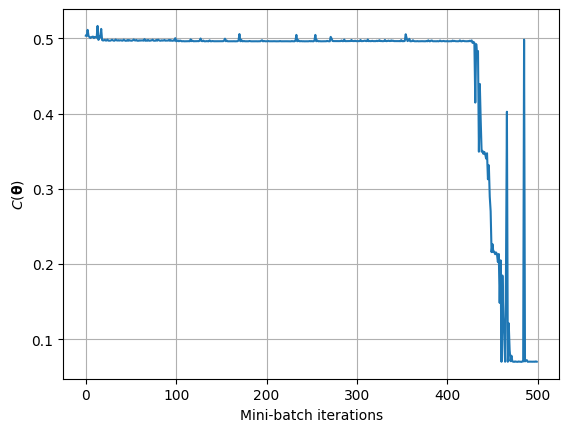

In [17]:
plt.plot(opt_results['loss_history'])
plt.xlabel('Mini-batch iterations')
plt.ylabel('$C(\boldsymbol{\\theta})$')
plt.grid()

## Validation

Now with a trained model (and thus $\boldsymbol{\theta}^{\star}$), the anomaly score of an unseen time series $\boldsymbol{y}$ can be calculated

$$
a_X[\boldsymbol{y}] := |2C(\boldsymbol{\theta}^{\star}) - 2P_{\boldsymbol{\tau}}(\boldsymbol{\sigma})  - C_2[\boldsymbol{y}, \boldsymbol{\theta}^{\star}]|.
$$

When $a_X[\boldsymbol{y}] > \zeta$, $\boldsymbol{y}$ is considered anomalous. Below $\zeta$, $\boldsymbol{y}$ is considered normal. In validation, using a set of normal instances and a set of labelled anomalous instances, we can tune the threshold $\zeta$ to maximize some performance metric, which we choose to be the balanced accuracy score.

To do any of this, we first need a `@ct.electron` to calculate the anomaly score

In [18]:
@ct.electron
def get_anomaly_scores(Xte, penalty, tau, results_dict, M_sample_func, wires, k, embed_func, N_E,
                       transform_func, diag_func, observable):
    opt_params = results_dict['opt_params']
    alpha = opt_params['alpha']
    mu = opt_params['mu']
    sigma = opt_params['sigma']
    eta_0 = opt_params['eta_0']
    normal_cost = np.min(results_dict['loss_history'])
    scores = torch.zeros(Xte.shape[0])
    for i, yt in enumerate(Xte):
        single_time_series_cost =\
            get_time_series_cost(yt, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
                         transform_func, diag_func, observable, t_cycler=None)
        # scores[i] = (normal_cost - 0.5*single_time_series_cost - penalty(sigma, tau)).abs()
        anom_score = 2*normal_cost - 2*penalty(sigma, tau) - single_time_series_cost
        scores[i] = single_time_series_cost
    return scores

Now, given an arbitary $\zeta$, we need a function which returns predictions and labels

In [19]:
@ct.electron
def get_label_prediction_pairs(normal_scores, anomalous_scores, threshold):
    # -1: normal, 1: anomalous
    normal_predictions = [-1 if score.item() < threshold else 1 for score in normal_scores]
    normal_labels = [-1 for i in range(len(normal_scores))]

    anomalous_predictions = [1 if score.item() >= threshold else -1 for score in anomalous_scores]
    anomalous_labels = [1 for i in range(len(anomalous_scores))]

    labels = []; labels.extend(normal_labels); labels.extend(anomalous_labels)
    predictions = []; predictions.extend(normal_predictions); predictions.extend(anomalous_predictions)
    return predictions, labels

a balanced accuracy score

In [20]:
@ct.electron
def balanced_acc_score(truth, prediction):
    acc = balanced_accuracy_score(truth, prediction)
    return acc

and an electron to looop through $\zeta$ on arbitarily fine grid, and calculate balanced accuracy scores

In [21]:
@ct.electron
def threshold_scan(scores_norm, scores_val, threshold_grid_steps):
    zetas = np.linspace(0, 1, threshold_grid_steps)
    accs = []
    for zeta in zetas:
        pred, lab = get_label_prediction_pairs(scores_norm, scores_val, zeta)
        acc = balanced_acc_score(lab, pred)
        accs.append(acc)
    best_idx = np.argmax(accs)
    best_zeta = zetas[best_idx]
    best_acc = accs[best_idx]
    return zetas, accs, best_zeta, best_acc


Now we make a lattice to for the whole validation process

In [22]:
@ct.lattice
def validation_workflow(X_norm_path, X_val_path, threshold_grid_steps, penalty, tau,
                        results_dict, M_sample_func, wires, k, embed_func, N_E, transform_func,
                        diag_func, observable):

    Xte_norm = load_data_from_pickle(X_norm_path)
    Xval = load_data_from_pickle(X_val_path)

    # check dimensions of input data are correct
    data_santity_check(Xte_norm)
    data_santity_check(Xval)
 
    scores_norm = get_anomaly_scores(Xte_norm[:, :, ::4], penalty, tau, results_dict,
                                 M_sample_func, wires, k, embed_func, N_E,
                                 transform_func, diag_func, observable)
                                 
    scores_val = get_anomaly_scores(Xval[:, :, ::4], penalty, tau, results_dict,
                                    M_sample_func, wires, k, embed_func, N_E,
                                    transform_func, diag_func, observable)
    
    zetas, accs, best_zeta, best_acc = threshold_scan(scores_norm, scores_val, threshold_grid_steps)

    return zetas, accs, best_zeta, best_acc

and dispatch it to the `Covalent` server

In [23]:
dispatch_id = ct.dispatch(validation_workflow)(X_norm_path="".join([base_path, "/data/separated_data/Xte_norm.pickle"]),
                                               X_val_path="".join([base_path, "/data/separated_data/Xval.pickle"]),
                                               threshold_grid_steps=10000,
                                               penalty=arctan_penalty,
                                               tau=5,
                                               results_dict=opt_results,
                                               M_sample_func=sample_M,
                                               wires=range(n_qubits),
                                               k=2,
                                               embed_func=qml.templates.AngleEmbedding,
                                               N_E=10,
                                               transform_func=qml.templates.StronglyEntanglingLayers,
                                               diag_func=create_diagonal_circuit,
                                               observable=[qml.PauliZ(i) for i in range(n_qubits)])

ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
zetas, accs, best_zeta, best_acc = ct_results.result

Looking at the validation workflow in the `Covalent` GUI, we see that there were many opportunities for parallelization with `Dask` (disconnected graphs of electrons)

![validation](./images/validation_workflow_screenshot.png)

We can plot $\zeta$ versus accuracy score to gain some intuition on the sensitivity to $\zeta$

best zeta is 0.0012001200120012002 achieving a balanced accuracy score of 0.6583333333333333


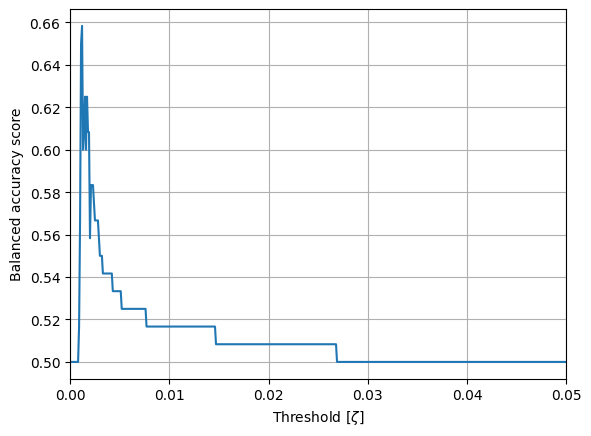

In [24]:
plt.figure()
plt.plot(zetas, accs)
plt.grid()
plt.xlabel('Threshold [$\zeta$]')
plt.ylabel('Balanced accuracy score')
plt.xlim(0, 0.05)

print('best zeta is', best_zeta, 'achieving a balanced accuracy score of', best_acc)

## Testing

Now with the optimal $\zeta$ set from validation, let's see how well we can do with a testing dataset, specifically, $\tilde{\mathcal{U}}_+$ from the article.

We shall test the balanced accuracy score and the $F_1$ score. This means we need one more electron for the latter

In [25]:
@ct.electron
def get_F1_score(truth, pred):
    score = f1_score(truth, pred)
    return score

Now we need only make a testing workflow

In [26]:
@ct.lattice
def testing_workflow(X_norm_path, X_anom_path, best_zeta, penalty, tau,
                        results_dict, M_sample_func, wires, k, embed_func, N_E, transform_func,
                        diag_func, observable):
    Xte_norm = load_data_from_pickle(X_norm_path)
    Xte_anom = load_data_from_pickle(X_anom_path)

    # check dimensions of input data are correct
    data_santity_check(Xte_norm)
    data_santity_check(Xte_anom)
    
    scores_norm = get_anomaly_scores(Xte_norm[:, :, ::4], penalty, tau, results_dict,
                                 M_sample_func, wires, k, embed_func, N_E,
                                 transform_func, diag_func, observable)
                                 
    scores_anom = get_anomaly_scores(Xte_anom[:, :, ::4], penalty, tau, results_dict,
                                    M_sample_func, wires, k, embed_func, N_E,
                                    transform_func, diag_func, observable)
                                    
    predictions, labels = get_label_prediction_pairs(scores_norm, scores_anom, best_zeta)

    acc_score = balanced_acc_score(labels, predictions)
    f1_score = get_F1_score(labels, predictions)

    return acc_score, f1_score, scores_norm, scores_anom

and dispatch it

In [27]:
dispatch_id = ct.dispatch(testing_workflow)(X_norm_path="".join([base_path, "/data/separated_data/Xte_norm.pickle"]),
                                               X_anom_path="".join([base_path, "/data/separated_data/Xte_dirty_usdt_pos.pickle"]),
                                               penalty=arctan_penalty,
                                               best_zeta=best_zeta,
                                               tau=5,
                                               results_dict=opt_results,
                                               M_sample_func=sample_M,
                                               wires=range(n_qubits),
                                               k=2,
                                               embed_func=qml.templates.AngleEmbedding,
                                               N_E=10,
                                               transform_func=qml.templates.StronglyEntanglingLayers,
                                               diag_func=create_diagonal_circuit,
                                               observable=[qml.PauliZ(i) for i in range(n_qubits)])

ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
acc_score, f1_score , scores_norm, scores_anom = ct_results.result

Similarly to the validation workflow, the testing workflow also utilizes heavy `Dask` parallelization

![testing](./images/testing_workflow_screenshot.png)

Print the accuracy score and F1 score and show box plots of the anomaly scores

In [28]:
print('For testing set pair N and \\tilde{U}_+, scores are...')
print('Balanced accuracy score:', acc_score)
print('F1 score:', f1_score)

For testing set pair N and \tilde{U}_+, scores are...
Balanced accuracy score: 0.7416666666666667
F1 score: 0.7801418439716312


Text(0, 0.5, 'Anomaly score')

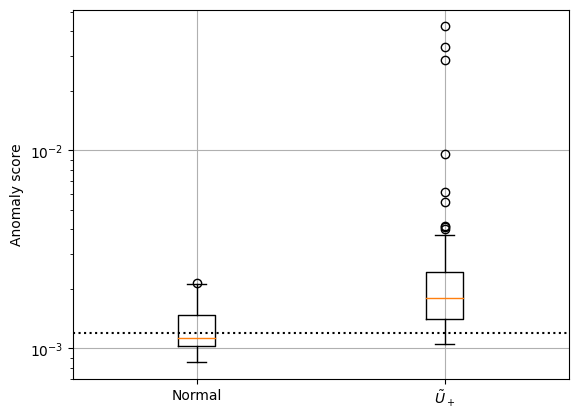

In [29]:
boxes = plt.boxplot([scores_norm.detach().numpy(), scores_anom.detach().numpy()], labels=['Normal', '$\\tilde{U}_+$'])
plt.axhline(best_zeta, linestyle=':', color='k')
plt.grid()
plt.yscale('log')
plt.ylabel('Anomaly score')